In [1]:
#%matplotlib inline  
%pylab inline

import pandas as pd
import numpy as np


# function to get age group
def getAgeGrp( age ):
    age = int(age)
    if age <= 0:
        return np.nan
    elif age < 12:
        return 'group1'
    elif age < 18 and age >= 12:
        return 'group2'
    elif age < 30 and age >= 18 :
        return 'group3'
    else:
        return 'Adult'
    



Populating the interactive namespace from numpy and matplotlib


In [2]:
# load up labeled condition
file = '../accByKeithLabel.txt'
df =  pd.read_csv( file,sep=',',names=['subid', 'trial', 'block', 'acc', 'RT', 'age']).dropna()

# define which columns labeled
labInd = [ True]*12 + [True, True, False, False, True,True,False,False, True,True,False,False]*3
df['isLabeled'] = df.trial.apply(lambda(x):labInd[x-1] )
df['condLab'] = 1
df[ 'pracBlock'] = df[ 'block']
df.pracBlock.loc[ df.trial < 9] = 0   
dfLab =df

# load up besline condition
file = '../accByKeith.txt'
df =  pd.read_csv( file,sep=',',names=['subid', 'trial', 'block', 'acc', 'RT', 'age']).dropna()
# define which columns labeled
df['isLabeled'] = False #df.trial.apply(lambda(x):labInd[x-1] )
df['condLab'] = 0
df[ 'pracBlock'] = df[ 'block']
df.pracBlock.loc[ df.trial < 9] = 0   
# concatenate
df = pd.concat( [dfLab, df], ignore_index=True)
dfLab =df

# load up supervised condition
file = '../accByKeithSup.txt'
df =  pd.read_csv( file,sep=',',names=['subid', 'trial', 'block', 'acc', 'RT', 'age']).dropna()
# define which columns labeled
df['isLabeled'] = df.trial.apply(lambda(x):labInd[x-1] )
df['condLab'] = 2
df[ 'pracBlock'] = df[ 'block']
df.pracBlock.loc[ df.trial < 9] = 0   
# concatenate
df = pd.concat( [dfLab, df], ignore_index=True)
dfLab =df

# load up ADULT besline condition
file = '../accByKeith_AdultBL.txt'
df =  pd.read_csv( file,sep=',',names=['subid', 'trial', 'block', 'acc', 'RT', 'age']).dropna()
# define which columns labeled
df['isLabeled'] = False #df.trial.apply(lambda(x):labInd[x-1] )
df['condLab'] = 0
df[ 'pracBlock'] = df[ 'block']
df.pracBlock.loc[ df.trial < 9] = 0 
df['age'] = 24*18
# concatenate
df = pd.concat( [dfLab, df], ignore_index=True)




# clear unecessary data
del dfLab






In [3]:
# df[df.condLab == 2]
# blockAcc

In [4]:
# get accuracy by block, add age groups
blockAcc = df.groupby( ['subid','pracBlock']).mean().reset_index()

blockCount = df.groupby( ['subid','pracBlock']).count() #.reset_index()
blockCount = blockCount['acc'].reset_index()


# blockCount = df.groupby( ['subid','pracBlock']).count().reset_index()  # nan dropped at loading
blockAcc[ 'count'] = blockCount['acc']

blockAcc['ageGrps'] = blockAcc.age.apply( lambda(x): getAgeGrp(x))
df['ageGrps'] = df.age.apply( lambda(x): getAgeGrp(x))

In [5]:
# find first peak and max accuracy block

def firstPeak( acc ):
    ' find first peak and index of a series'
    bPeak, aPeak = (1, acc.iloc[1])   # skip block 0 (practice)
    # loop through and find first peak
    for block,a in enumerate(acc):
        if block == 0:
            pass
        elif a > aPeak:
            bPeak = block
            aPeak = a
        elif a == aPeak:
            pass
        else:
            break            
    return bPeak, aPeak

def maxPeak( acc ):    
    'Find maximum value and index of a series'
    bMax, aMax = (1, acc.iloc[1])    # skip block 0 (practice)
    # loop through and find max accuracy
    for block,a in enumerate(acc):
        if block == 0:
            pass
        elif a > aMax:
            bMax = block
            aMax = a
    return bMax, aMax
        
#---------------------------------------------


# go through each block and find peak and max accuracy

dfToPeak = pd.DataFrame()
blockAccToPeak = pd.DataFrame()

for s in blockAcc.subid.unique():
    x = blockAcc[ blockAcc.subid == s]    
    bPeak, aPeak = firstPeak( x.acc )
    bMax, aMax = maxPeak( x.acc)    
#     print s, x.acc, bPeak, aPeak, '\n'
#     print x.acc, bMax, aMax

    # df.loc[row_indexer,column_indexer]
    blockAcc.loc[ blockAcc.subid ==s, 'peakBlock'] = bPeak
    blockAcc.loc[ blockAcc.subid ==s, 'maxBlock'] = bMax
    df.loc[ df.subid ==s, 'peakBlock'] = bPeak
    df.loc[ df.subid ==s, 'maxBlock'] = bMax
  
    dfToPeak = pd.concat( [ dfToPeak, df[(df.subid == s) &( df.pracBlock <= bPeak )]  ], ignore_index=True)
    blockAccToPeak  = pd.concat( [ blockAccToPeak, blockAcc[(blockAcc.subid == s) &( blockAcc.pracBlock <= bPeak )]  ], ignore_index=True)
# blockAcc[ blockAcc.peakBlock != 1]

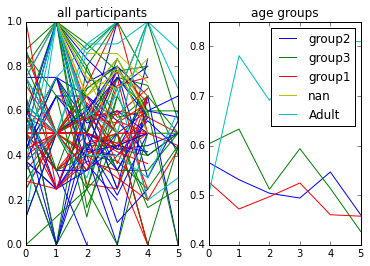

In [6]:
# show accuracy trends
gCol = { 'group1':'r-', 'group2':'b-', 'group3':'g-', 'Adult':'c-','nan':'y-'}

subplot(121)
title( 'all participants')
for s in blockAcc.subid.unique():
    sub = blockAcc[ blockAcc.subid == s]
    plot( sub.pracBlock, sub.acc, gCol[ str(sub.iloc[0].ageGrps)] )
    
subplot(122)
title( 'age groups')
for g in blockAcc.ageGrps.unique():
    sub = blockAcc[ blockAcc.ageGrps == g].groupby('pracBlock').mean().reset_index()    
    plot( sub.pracBlock, sub.acc, gCol[str(g)], label=g )
legend()    
    


In [7]:
# export to csv
blockAcc.to_csv( 'blockAccBaselineAndLabel.txt' ,sep = ',')
df.to_csv( 'trialAccBaselineAndLabel.txt' ,sep = ',')

blockAccToPeak.to_csv( 'blockAccToPeak1.txt' ,sep = '\t')
dfToPeak.to_csv( 'trialAccToPeak1.txt' ,sep = '\t')

In [8]:
# make tables to do some stats
    # get trails from the 2 highest blocks, check acc vs chance (50%)
    # ignore first block
    
labCond = 0 # 1-label; 0-baseline; 2 supervised  
grp = 'group3'



bAcc = blockAcc[(blockAcc.block >1) & (blockAcc.ageGrps == grp  ) & (blockAcc.condLab == labCond)] # skip first block, only ages >= 15
dfAfter1 = df[ (df.block > 1)& (df.age >= 15 ) & (df.condLab == labCond)]

bestBlocks = pd.DataFrame()  # to store trials from 2 best blocks
worstBlocks = pd.DataFrame() # to store trials from 2 worst blocks

# loop through participants, get 
for s in bAcc.subid.unique():
    thisSub = bAcc[ bAcc.subid == s].sort( columns='acc',ascending=False)
    
    # get good blocks
    bIdxGood = thisSub.block.iloc[0:2]  
    for b in bIdxGood:
        bestBlocks = pd.concat( [ bestBlocks,dfAfter1[ (dfAfter1.subid == s ) & ( dfAfter1.block == b) ] ], ignore_index= True)
    
    # get trials from remaining blocks
    tempBad = dfAfter1[ dfAfter1.subid == s]
    for b in bIdxGood:
        tempBad = tempBad[ tempBad.block != b]
    worstBlocks = pd.concat( [ worstBlocks,tempBad ], ignore_index= True)
    
   
 

In [9]:
# look at the best/worst and see if different from 50%

from scipy import stats

goodAcc = bestBlocks.groupby( 'subid').mean()
(t,prob) = stats.ttest_1samp(goodAcc.acc, .5 )
print 'good blocks: (t,p-val)', t,prob

badAcc = worstBlocks.groupby( 'subid').mean()
(t,prob) = stats.ttest_1samp(badAcc.acc, .5 )
print 'bad blocks: (t,p-val)', t,prob


allAcc = dfAfter1.groupby( 'subid').mean()
(t,prob) = stats.ttest_1samp(allAcc.acc, .5 )
print 'all blocks: (t,p-val)', t,prob


print 'means good, bad, all:', mean( goodAcc.acc), mean( badAcc.acc), mean( allAcc.acc)


# print thisSub.block
# bAcc

good blocks: (t,p-val) 3.32683535865 0.00603334318495
bad blocks: (t,p-val) -3.51768151889 0.00481805906791
all blocks: (t,p-val) 2.48352474015 0.0192649143267
means good, bad, all: 0.611943724292 0.370455586081 0.587057672975


In [10]:
# blockAcc
# worstBlocks
# df.ageGrps.unique()



In [11]:
# now get accuracy for a sliding window
# df.condLab.value_counts()
# df[df.ageGrps == 'Adult'] 

In [12]:
def slideAcc( acc, window=6 ):
    # return a sliding window average of accuracy 
    N = len(acc)
    wAcc = np.zeros((N))*np.nan
    for i1 in range(window,N+1):      
        a = acc.values[i1-window:i1]
        #print i1, a
        wAcc[i1-1] = nanmean(a) # get mean over window    
    return wAcc


    #figure()
    #plot( df[ df.subid ==s].trial, df[ df.subid ==s].windAcc, '.-' )
    

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


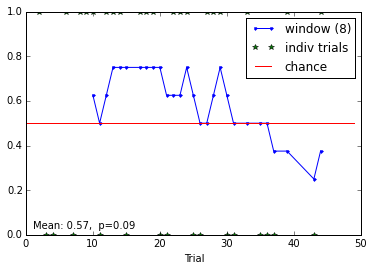

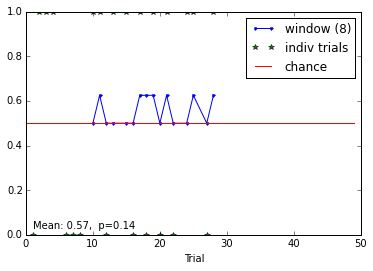

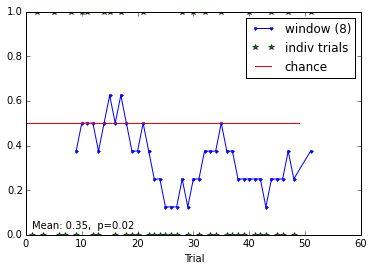

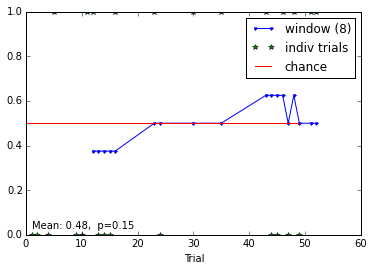

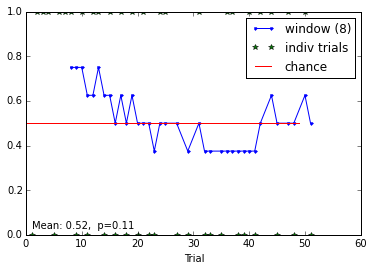

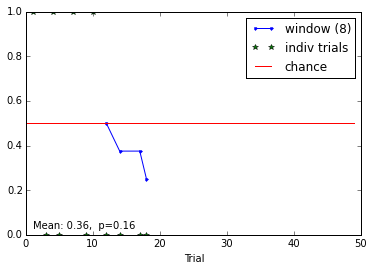

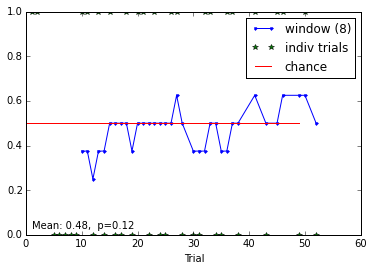

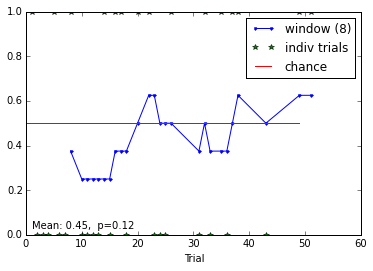

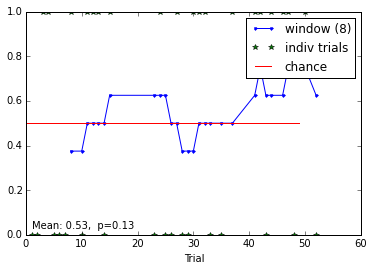

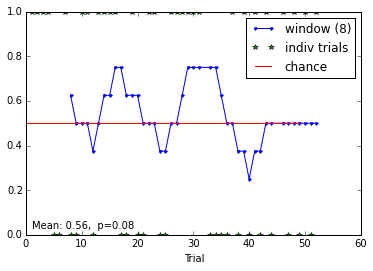

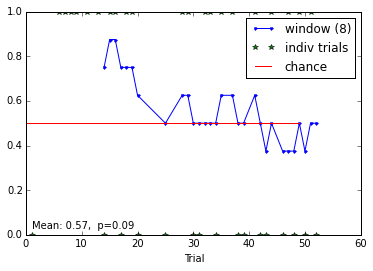

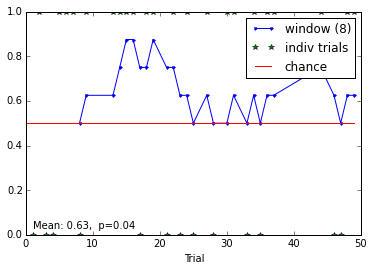

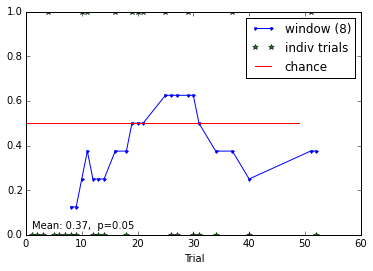

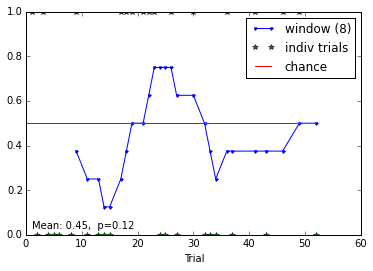

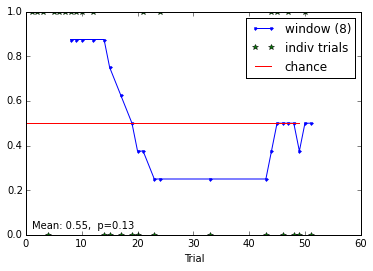

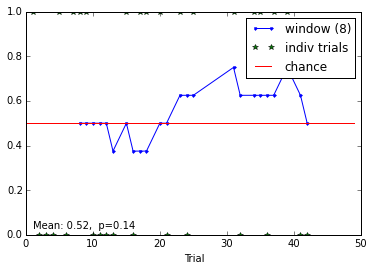

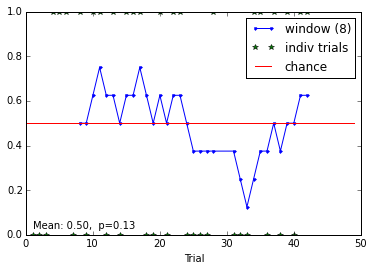

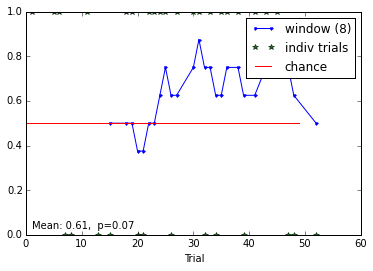

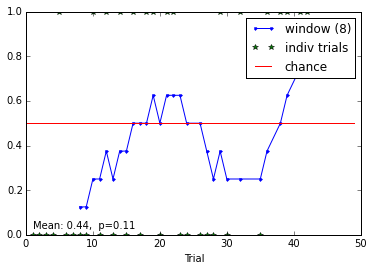

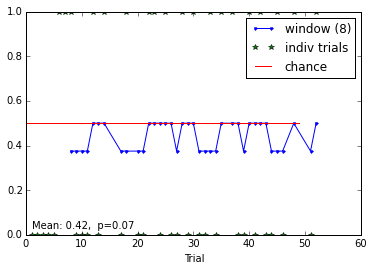

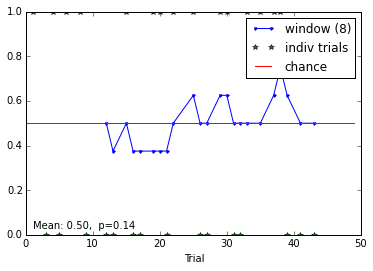

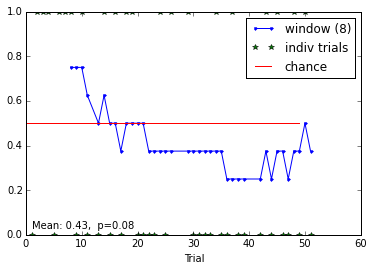

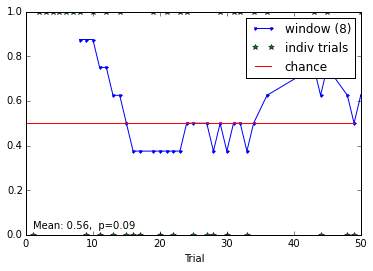

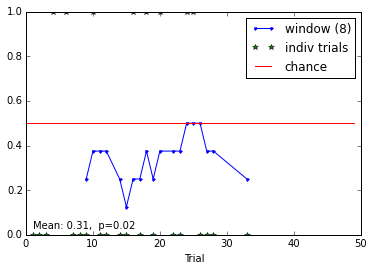

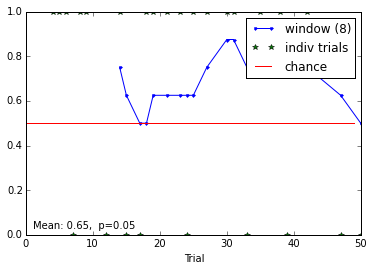

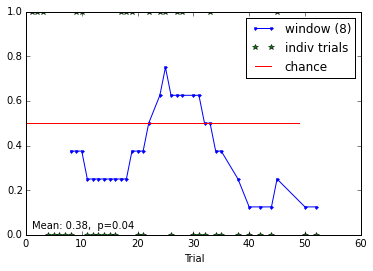

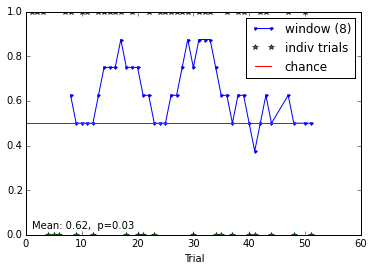

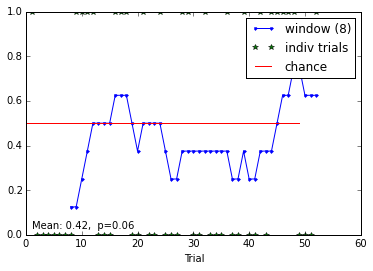

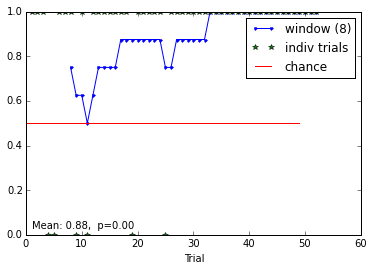

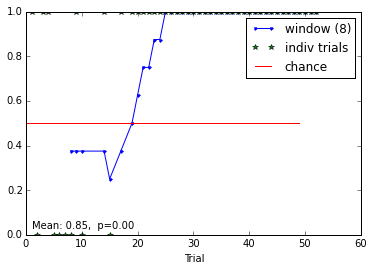

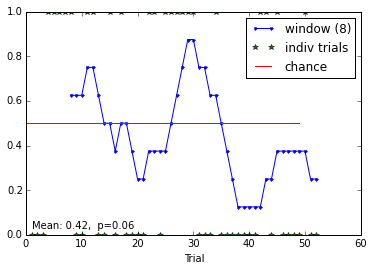

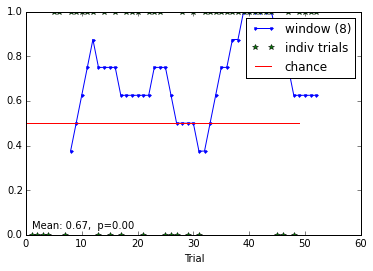

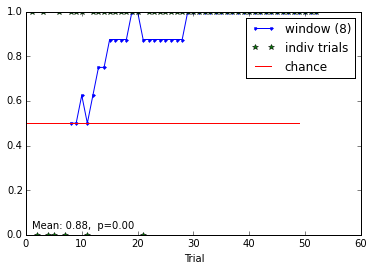

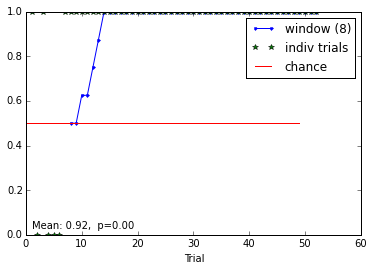

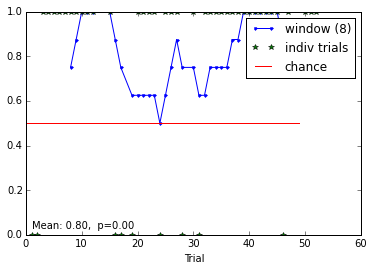

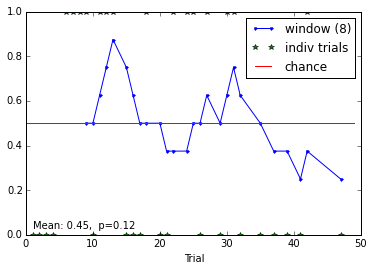

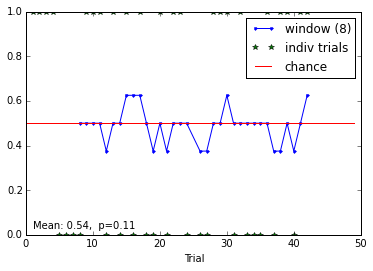

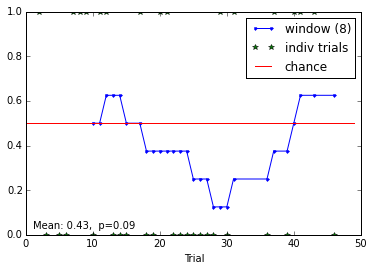

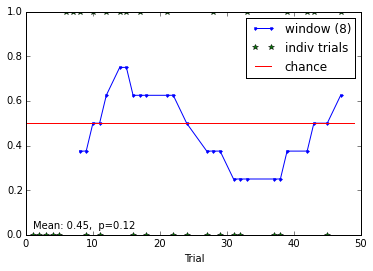

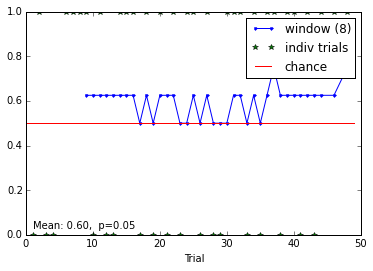

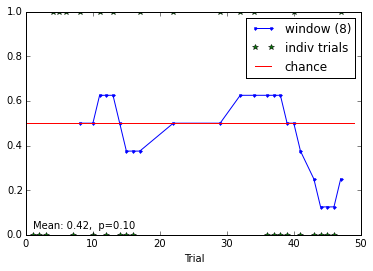

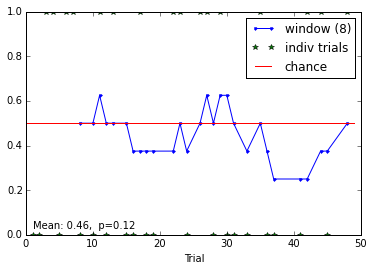

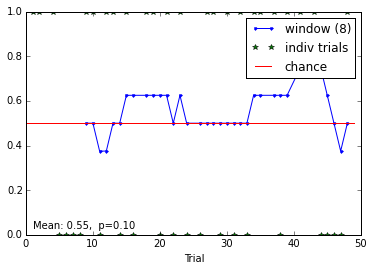

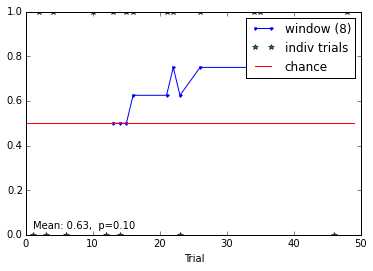

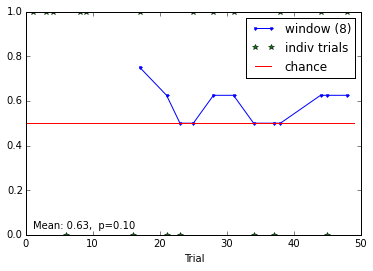

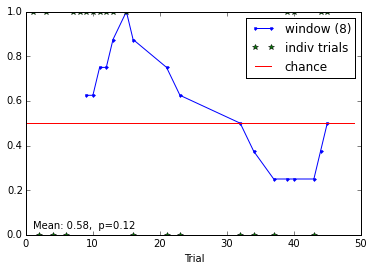

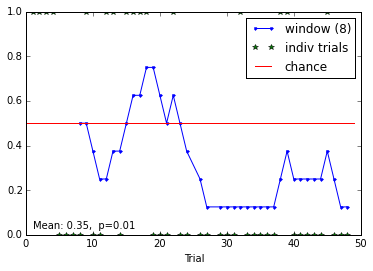

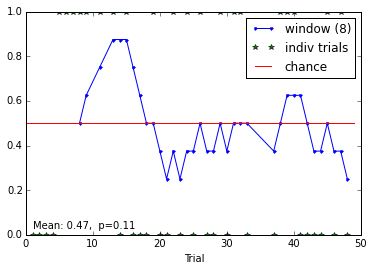

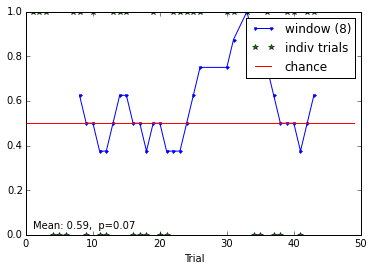

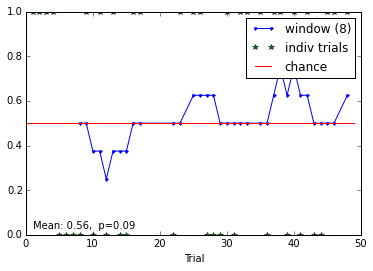

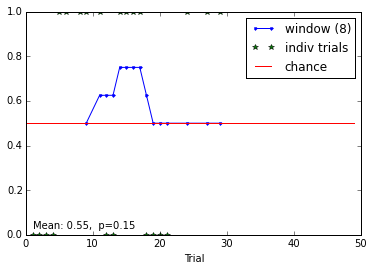

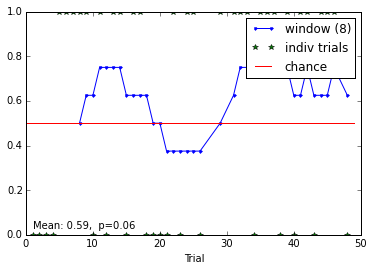

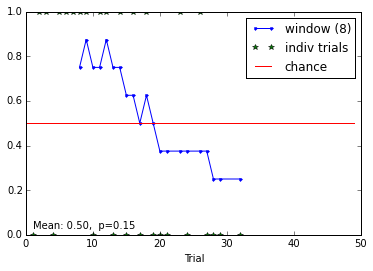

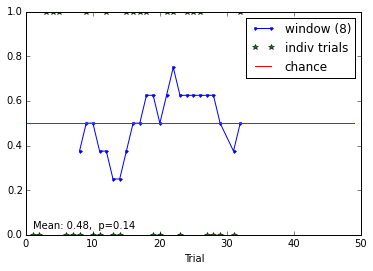

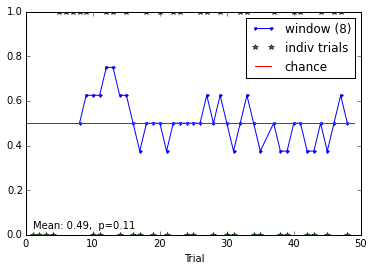

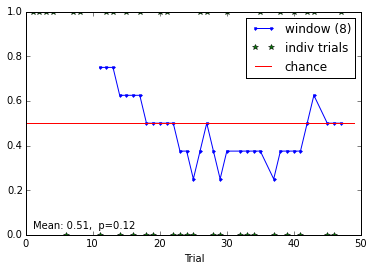

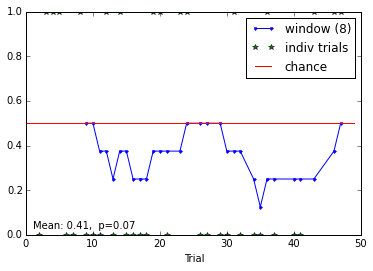

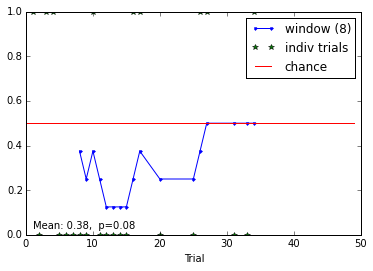

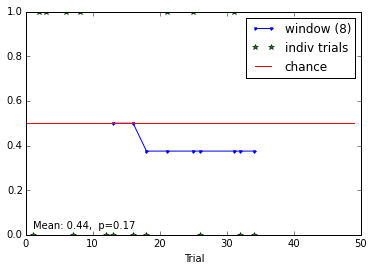

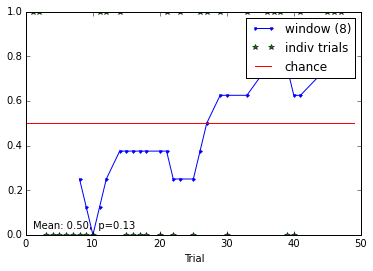

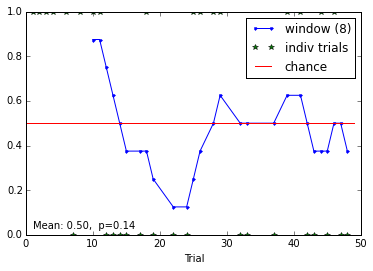

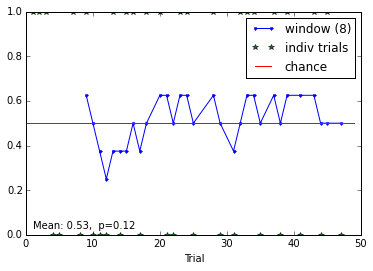

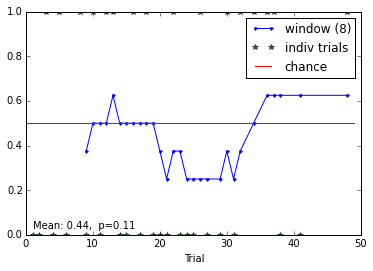

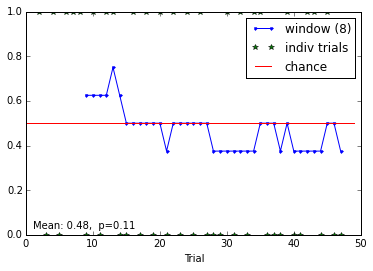

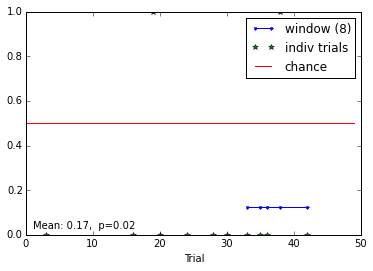

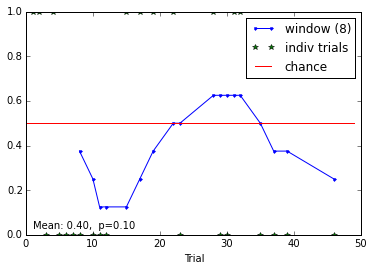

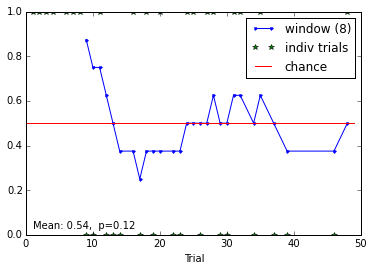

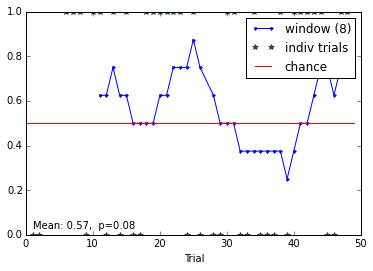

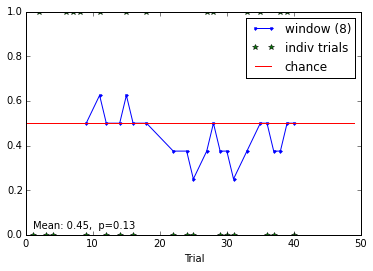

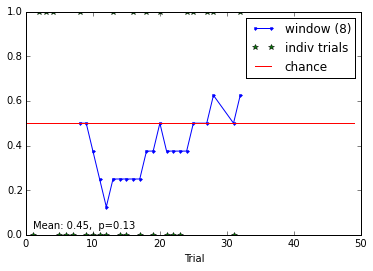

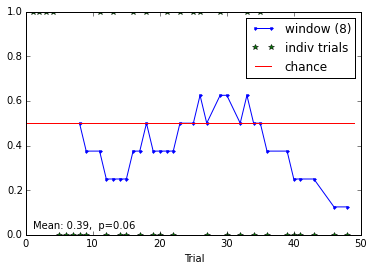

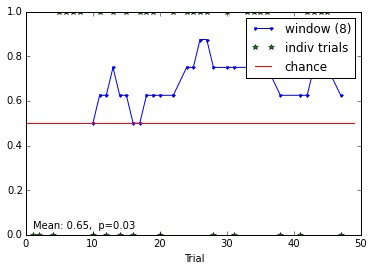

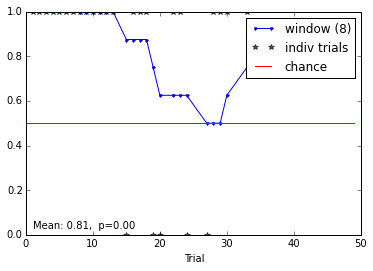

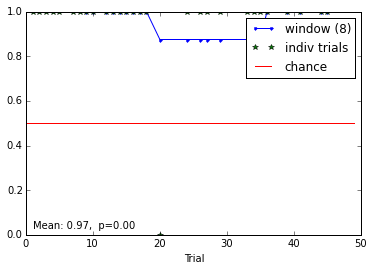

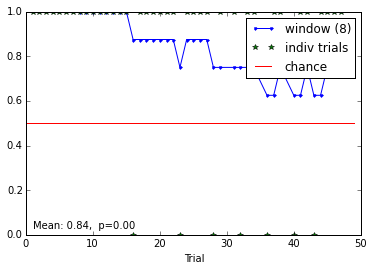

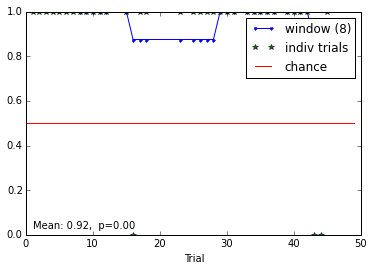

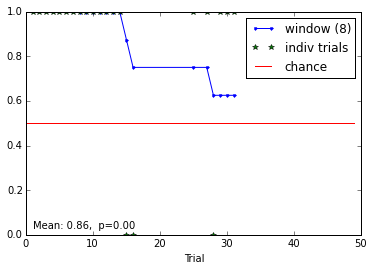

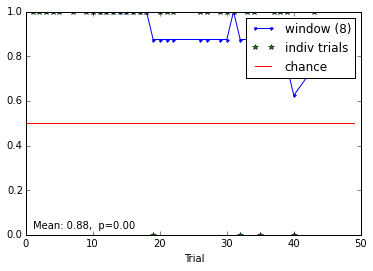

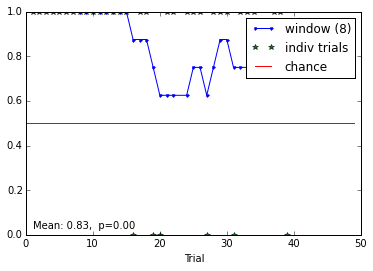

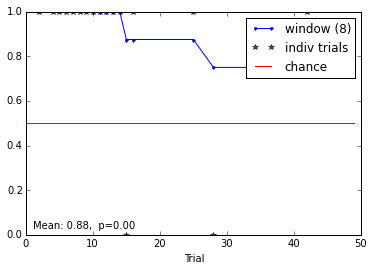

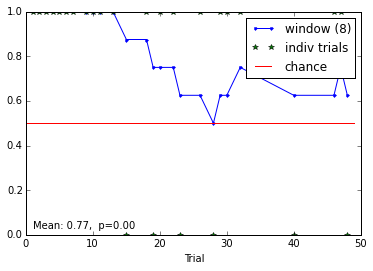

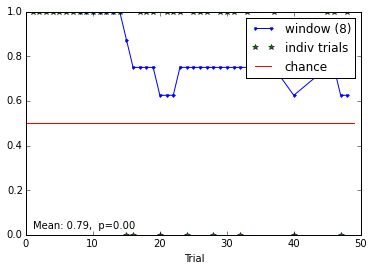

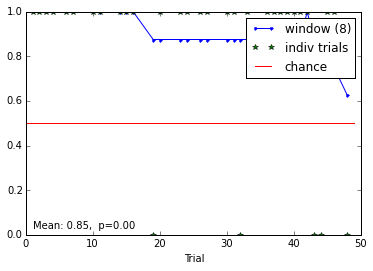

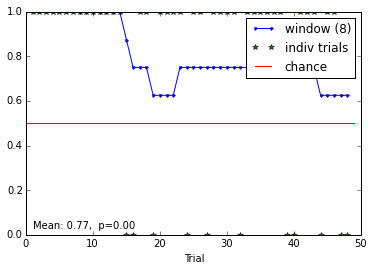

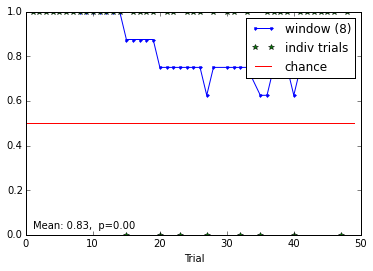

In [13]:
from scipy.stats import binom
import matplotlib.backends.backend_pdf as pdfOut


# go through each subject, add accuracy over sliding window
w = 8
df[ 'windAcc']  = np.nan
for s in df.subid.unique():
    acc = df[ df.subid ==s].acc
    df.ix[df.subid ==s, 'windAcc' ] = slideAcc( acc, window=w )
    

df['isLearner'] = np.nan
    
    
#only children    
# df = df[ df.ageGrps != 'Adult']    
    

# ageGrp = 'group3' # 'Adult' 
pList = []
mList = []
subList = []
showFig = True


#for output
#pdf = pdfOut.PdfPages( 'curves%sCond%d.pdf'%(ageGrp, cond))


# show learning curves for some condition 
for cond in [0,1,2]:
    
    # for s in df[df.condLab == cond].subid.unique():   
    for s in df[(df.condLab == cond) ].subid.unique():    #& (df.ageGrps == ageGrp)

        a = df[ df.subid ==s].acc
        x, n = sum(a), len(a)
        pVal = binom.pmf(x, n, .5)
        
        # add learning status to dataframe
        if (nanmean(a) > .5) and (pVal < .1):
            learned=1
        else:
            learned=0
        df.ix[df.subid==s,'isLearner'] = learned
        df.ix[df.subid==s,'pVal'] = pVal

        # Plot
        if showFig:
            fig = figure()   
            plot( df[ df.subid ==s].trial, df[ df.subid ==s].windAcc, 'b.-', label='window (%d)'%w )
            plot( df[ df.subid ==s].trial, df[ df.subid ==s].acc, 'g*', label ='indiv trials' )       
            plot( np.arange(0,50),[.5]*50, 'r-', label='chance')  # chance line    
            text(1, .03,  'Mean: %.2f,  p=%.02f' % (mean(a) ,pVal) )
            xlabel('Trial')
            legend()       
            #pdf.savefig( fig )

        if len( a ) > 15:   #(at least 20 trials)  
            subList.append(s)
            pList.append(pVal)
            mList.append( mean(a))        

df.to_csv( 'trialAccAllAndLrnCrit.txt' ,sep = ',', index=False)    
#pdf.close()    


In [14]:
# pList = np.concatenate( (np.array(pList), np.array( mList)), axis=0)
pList = np.array( pList)
mList = np.array( mList)
subList = np.array(subList)


lrnSubs = subList[  (pList <.1) & (mList > .5)]
lrnPs = pList[ (pList <.1) & (mList > .5)]
nLrnPs = pList[ (pList <.1) & (mList < .5)]

# display things
print( '%d out of %d learned' % ( len(lrnPs),len(pList)))
print lrnSubs
print( '%d out of %d anti-learned' % ( len(nLrnPs),len(pList)))




35 out of 83 learned
[4749 4770 4773 4776 4792 4801 4803 4809 6378 6474 6519 6523 6528 6530 4836
 4846 4848 4854 4858 4862 4922 4932 5013 5014 5019 5021 5032 5040 5041 5050
 5054 5056 5061 5063 5064]
15 out of 83 anti-learned


In [15]:
# anonymize
'''
count = 0
for s in df.subid.unique():
    count+= 1
    df.ix[df.subid==s ,'subid'] = ('sub%d'% count)
    
df.to_csv( 'KARS_Anon.txt', sep=',', index=False)
'''

"\ncount = 0\nfor s in df.subid.unique():\n    count+= 1\n    df.ix[df.subid==s ,'subid'] = ('sub%d'% count)\n    \ndf.to_csv( 'KARS_Anon.txt', sep=',', index=False)\n"

In [16]:
# summarize which participants learned

dfLearner = df.groupby('subid', as_index=False).mean()
dfLearner.drop(['trial','block', 'RT', 'isLabeled', 'pracBlock', 'windAcc'], axis=1, inplace=True )
dfLearner.to_csv( 'subLrnSummary.txt' ,sep = ',', index=False)  
dfLearner

,subid,acc,age,condLab,peakBlock,maxBlock,isLearner,pVal
0,4749,0.571429,16,0,1,1,1,0.094528
1,4750,0.565217,24,0,1,3,0,0.136383
2,4756,0.354167,8,0,1,1,0,0.015079
3,4757,0.480000,22,0,1,4,0,0.154981
4,4758,0.522727,16,0,1,1,0,0.114404
5,4759,0.363636,12,0,1,1,0,0.161133
6,4761,0.476190,8,0,1,4,0,0.116823
7,4765,0.454545,16,0,2,5,0,0.120741
8,4768,0.527778,16,0,1,1,0,0.125110
9,4770,0.560000,16,0,3,3,1,0.078826


In [18]:
dfLearner.age

0     16
1     24
2      8
3     22
4     16
5     12
6      8
7     16
8     16
9     16
10     9
11    18
12    24
13    24
14    24
...
70     12
71     -1
72     -1
73     -1
74     -1
75     -1
76     -1
77    432
78    432
79    432
80    432
81    432
82    432
83    432
84    432
Name: age, Length: 85, dtype: float64